In [1]:
import numpy as np

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Simulated Callable Bond Price

In [2]:
y, price, priceC = generateSimulatedBDTPrice()

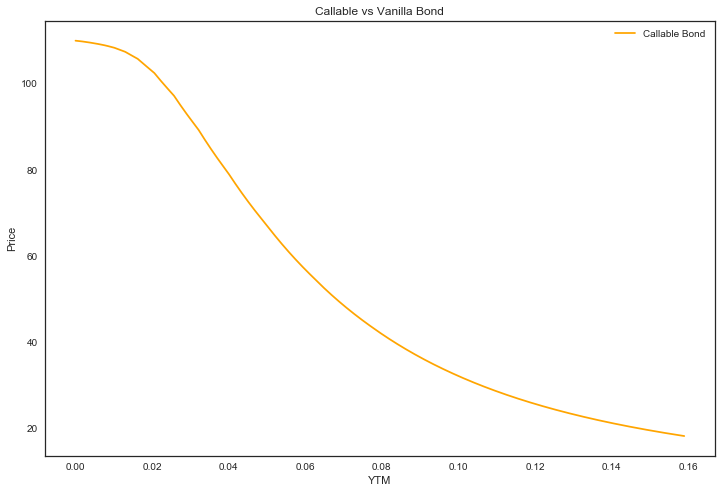

In [3]:
sns.set_style('white')
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(y,priceC,label='Callable Bond', c = 'orange')
ax.set_title('Callable vs Vanilla Bond')
ax.set_xlabel('YTM')
ax.set_ylabel('Price')
ax.legend()

In [4]:
def fit_simulated_BDT_with_rolling_window(window, degree_of_fit):
    # fit data with rolling window
    pure_X = y
    pure_Y = priceC

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.plot(y, priceC, c = 'orange', label = 'Theoretical value')
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 1 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, np.array(y), np.array(priceC), degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(y[window:], dt, s = 0.3, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 2 : Fitted Duration... ')
    ax.legend()

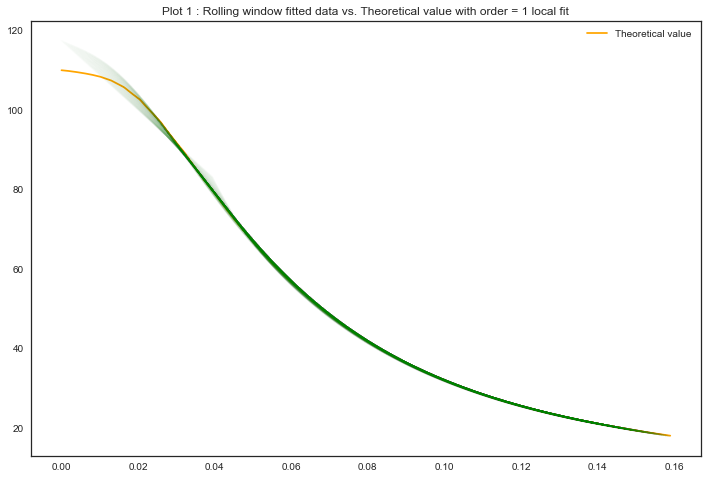

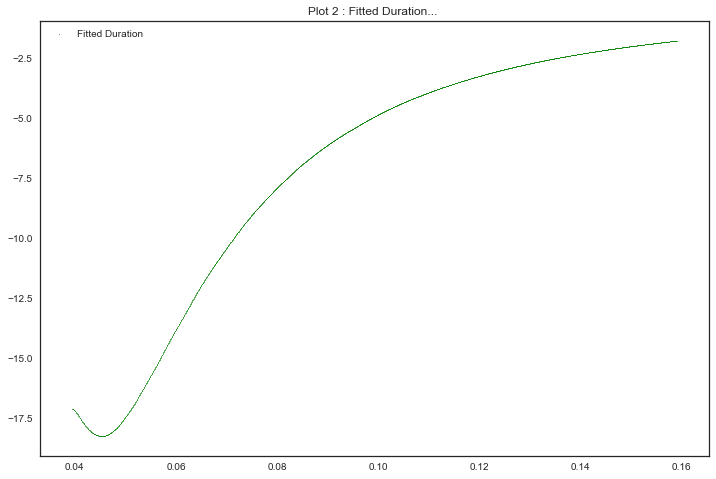

In [5]:
fit_simulated_BDT_with_rolling_window(window = 300, degree_of_fit = 1)

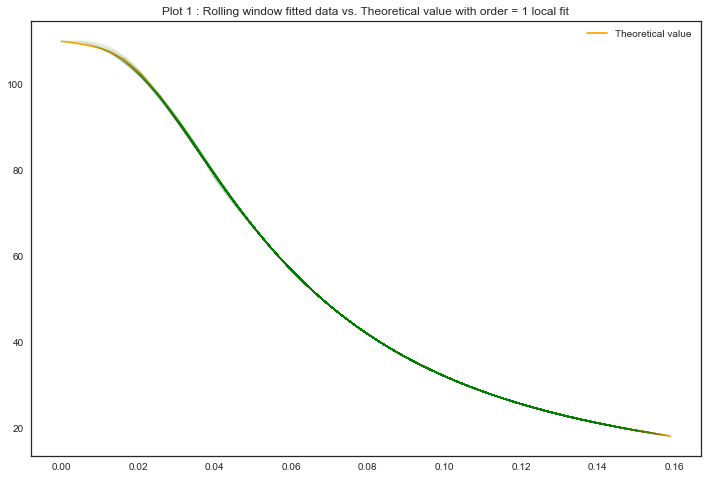

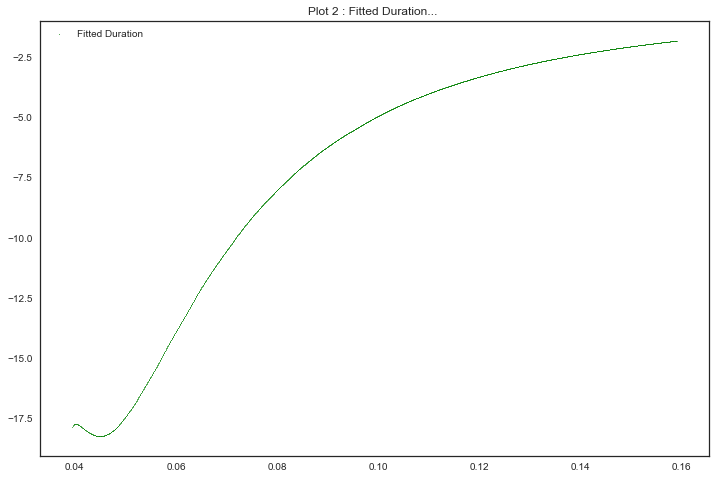

In [6]:
fit_simulated_BDT_with_rolling_window(window = 300, degree_of_fit = 2)

# 2. Price and interest rate as correlated time series data

In [7]:
class RateAndPriceSeriesGenerator():
    def __init__(self, price_vol, rate_vol, corr):
        covariance = corr * price_vol * rate_vol
        self.cov = np.array([[price_vol**2, covariance], [covariance, rate_vol**2]])
        
    def generate_series(self, initial_price, initial_rate, N = 1000, ar_coeff = 1):
        np.random.seed(542)
        x = np.random.multivariate_normal(np.array([0, 0]), self.cov, size = N - 1)
        prices = [initial_price]
        rates = [initial_rate]
        
        for i in np.arange(1, N):
            prices.append(prices[-1] * ar_coeff + x[i - 1, 0])
            rates.append(rates[-1] * ar_coeff + x[i - 1, 1])
            
        return np.array(prices), np.array(rates)

In [8]:
def fit_simulated_TS_with_rolling_window(price_vol, rate_vol, corr, initial_price, initial_rate, window, degree_of_fit):
    rpsg1 = RateAndPriceSeriesGenerator(price_vol = price_vol, rate_vol = rate_vol, corr = corr)
    prices, rates = rpsg1.generate_series(initial_price, initial_rate)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates, prices, s = 1.5, c = 'orange')
    ax.set_title('Plot 1 : Generated Data')
    
    # fit data with rolling window
    pure_X = rates
    pure_Y = prices

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(pure_X, pure_Y, c = 'orange', label = 'values', alpha = 0.5, s = 1.5)
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 2 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, rates, prices, degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates[window:], dt, s = 0.8, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 2 : Fitted Duration... ')
    ax.legend()

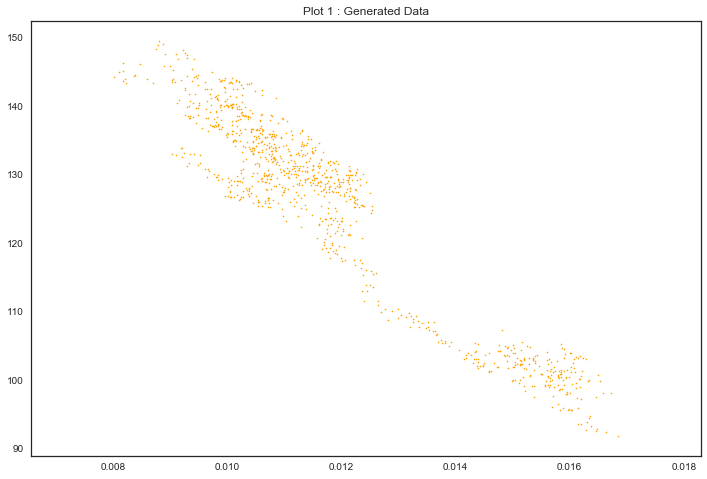

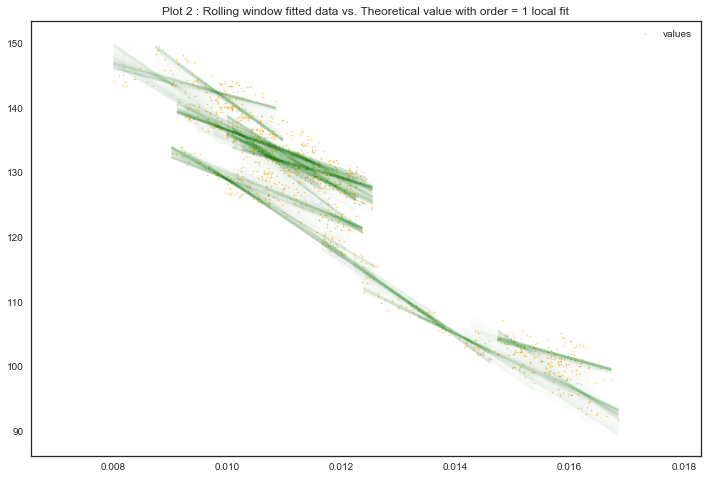

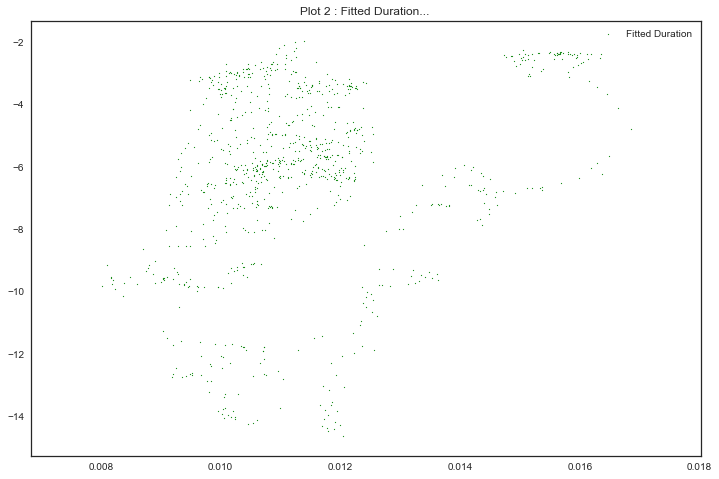

In [9]:
fit_simulated_TS_with_rolling_window(1, 0.0002, -0.8, 100, 0.015, 100, 1)

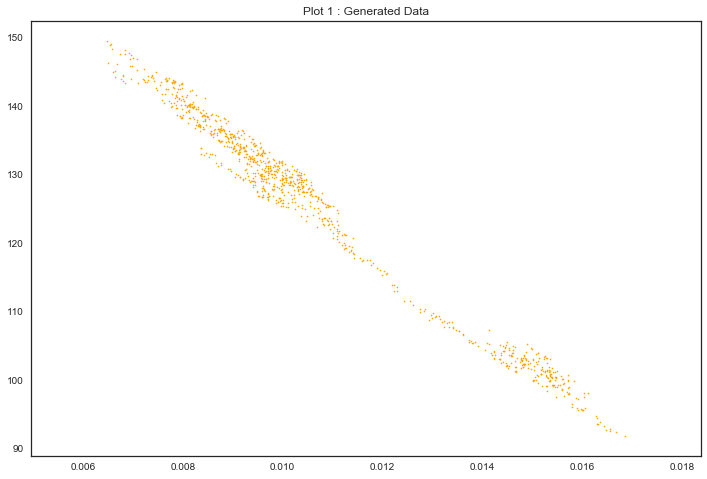

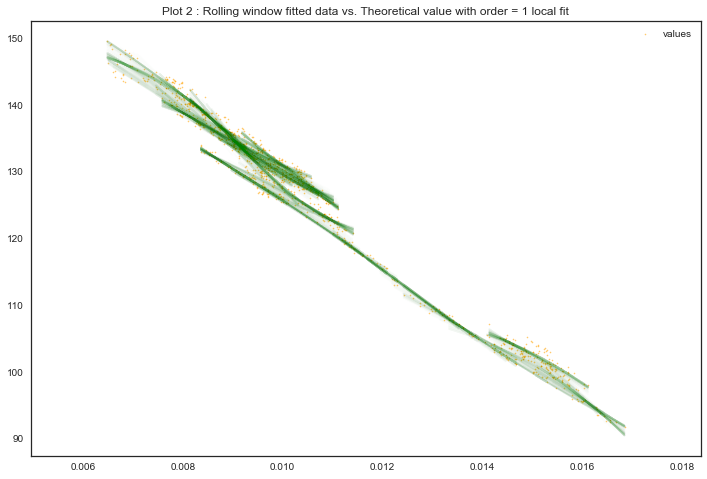

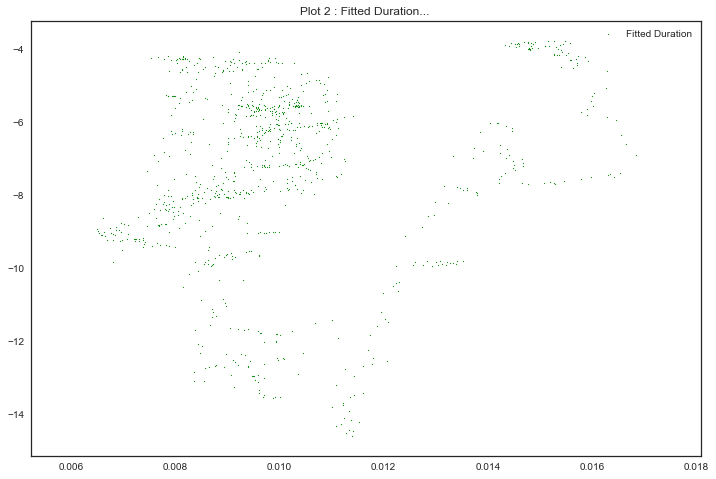

In [10]:
fit_simulated_TS_with_rolling_window(1, 0.0002, -0.95, 100, 0.015, 100, 2)

# 3. Only generate r as time series, calculate Price based on r

In [11]:
drift = 0.01
sigma = 0.4
n = 6
year = 30
cFrq = 2
c = 0.03
principle = 100
callPrice = 101
callTime = 3

def fit_simulated_TS_with_rolling_window(price_vol, rate_vol, corr, initial_price, initial_rate, window, degree_of_fit):
    rpsg1 = RateAndPriceSeriesGenerator(price_vol = price_vol, rate_vol = rate_vol, corr = corr)
    a, rates = rpsg1.generate_series(initial_price, initial_rate)

    prices = []
    for r in rates:
        prices.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPrice,callTime))
    prices = np.array(prices) + np.random.normal(loc = 0, scale = price_vol, size = len(prices))
    
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates, prices, s = 1.5, c = 'orange')
    ax.set_title('Plot 1 : Generated Data')
    
    # fit data with rolling window
    pure_X = rates
    pure_Y = prices

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(pure_X, pure_Y, c = 'orange', label = 'values', alpha = 0.5, s = 1.5)
    for i in range((len(pure_X) - window)):
        reg_X = pure_X[i:i + window]
        reg_Y = pure_Y[i:i + window]
        reg_X_new, a, b = orth_base(norm_base(np.array(reg_X)), degree_of_fit)

        coef = np.array(fitting_OLS(reg_Y, reg_X_new))
        fitted_Y = reg_X_new.dot(coef.reshape(-1, 1))
        ax.plot(reg_X, fitted_Y, c = 'green', alpha = 0.01)
    ax.set_title('Plot 2 : Rolling window fitted data vs. Theoretical value with order = 1 local fit')
    ax.legend()

    # test duration (first derivative) generated from orthogonal regression
    # d = poly_1st_derivative(x)

    dt = regression_poly_wind(window, rates, prices, degree_of_fit, duration_from_ortho_poly_fit, X_transformed = False, calc_derivative = True)

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.scatter(rates[window:], dt, s = 0.8, c = 'green', label = 'Fitted Duration')
    ax.set_title('Plot 3 : Fitted Duration... ')
    ax.legend()

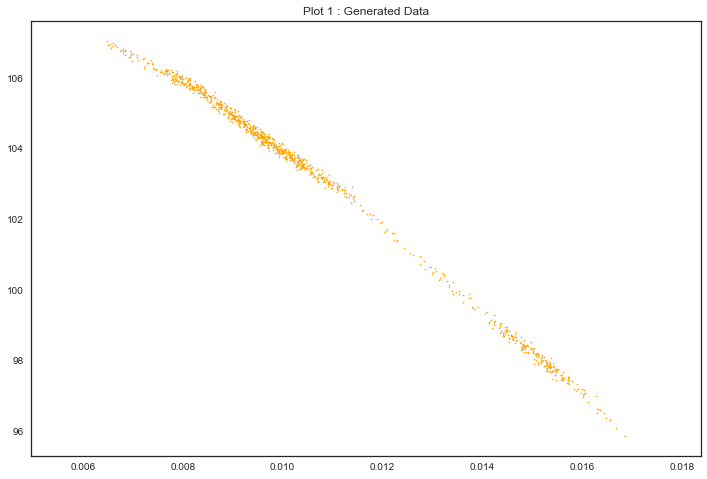

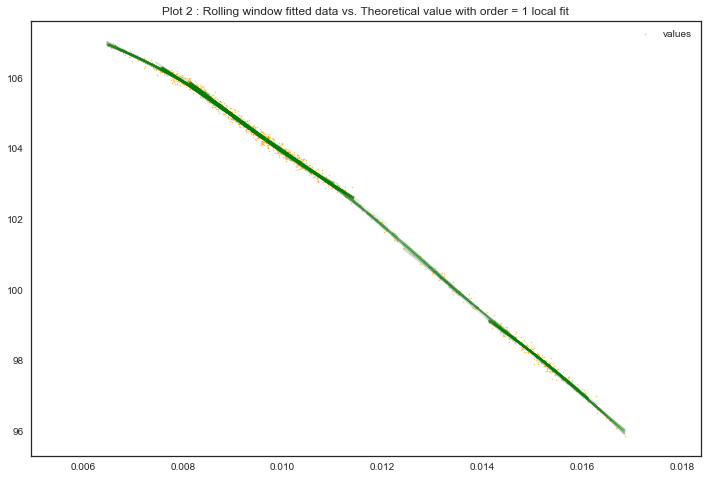

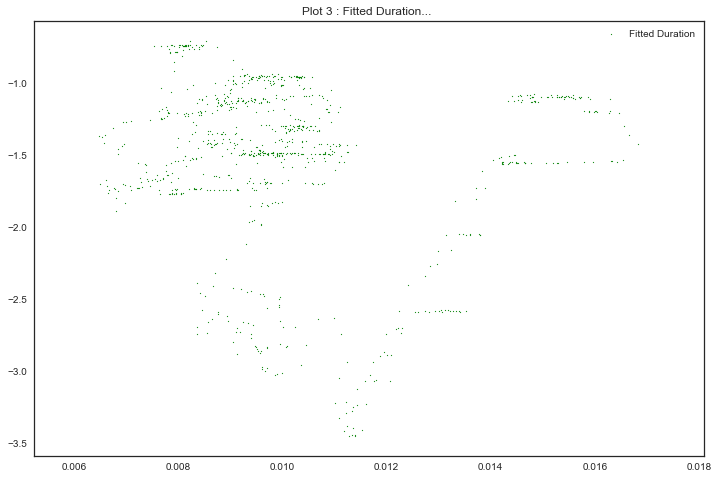

In [12]:
fit_simulated_TS_with_rolling_window(0.1, 0.0002, -0.95, 100, 0.015, 100, 2)

# 4. Hedging

In [13]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = '../data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

In [14]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x))

def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[0])
    for i in range(2,degree+1):
        a[i-1]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*np.multiply((x_n-a[i-1]),Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

def duration_from_ortho_poly_fit(X, Y, deg, rate):
    
    coef = np.array(fitting_OLS(Y, X))
    
    delta = 0.0001
    rate_plus = rate + delta
    rate_minus = rate - delta
    
    x_plus,a,b = orth_base(np.array([rate_plus]), deg)
    x_minus,a,b = orth_base(np.array([rate_minus]), deg)
    
    price_plus = np.sum(coef * x_plus)
    price_minus = np.sum(coef * x_minus)
    
    return - (price_plus - price_minus) / (delta * 2)

def regression_poly_wind_V2(wind, X, Y, deg, ploy_fit_func, rate):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    pure_X = X
    pure_Y = Y
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        beta.append(ploy_fit_func(reg_X, reg_Y, deg, rate))
        
    return beta

default_window = 60
degree = 1

poly_duration_without_order = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    default_start_date = min(dat.index)
    
    cur_list = []
    for p in period_list:
        window = default_window
        
        reg_start_date = p.startDate - dt.timedelta(days = window)
        if reg_start_date < default_start_date:
            reg_start_date = default_start_date
        
        rolling_period = len(dat[reg_start_date:p.endDate]['price'])
        if rolling_period < window:
            window = rolling_period // 2 + 1
        
        
        rates_raw = dat[reg_start_date:p.endDate]['MTGFNCL']
        
        # version 1 of poly fit: see above
        
        # normalize X
        rates = norm_base(rates_raw)
        # transform X to orthogonal basis
        reg_X, a, b = orth_base(rates, degree)
        betas = regression_poly_wind_V2(window, reg_X, dat[reg_start_date:p.endDate]['price'], degree, duration_from_ortho_poly_fit, rates[len(rates) - 1])
        cur_list.append(pd.DataFrame({'Duration': betas}, index = rates.index[window:]))
        
        # version 2 of poly fit: R package
        
        #betas = regression_poly_wind_V2(window, rates_raw, dat[reg_start_date:p.endDate]['price'], degree, duration_from_r_poly_fit, rates_raw[len(rates_raw) - 1])
        #print(len(betas))
        
        cur_list.append(pd.DataFrame({'Duration': betas}, index = rates_raw.index[window:]))
        
    poly_duration_without_order[c] = cur_list

## 4.1. Plot TBA prices vs Moneyness

$$\text{Moneyness}=\text{Coupon}-\text{10y Interst Rates}$$

In [15]:
df_aft2010=df['2010-01-01':]
moneyness=[]
for i,t in enumerate(np.array(df_aft2010.index)):
    moneyness.append(df_aft2010['coupon'][i]-float(rate_Base_raw[rate_Base_raw['Date']==str(t)[:10]]['TR']))
df_aft2010['moneyness']=moneyness

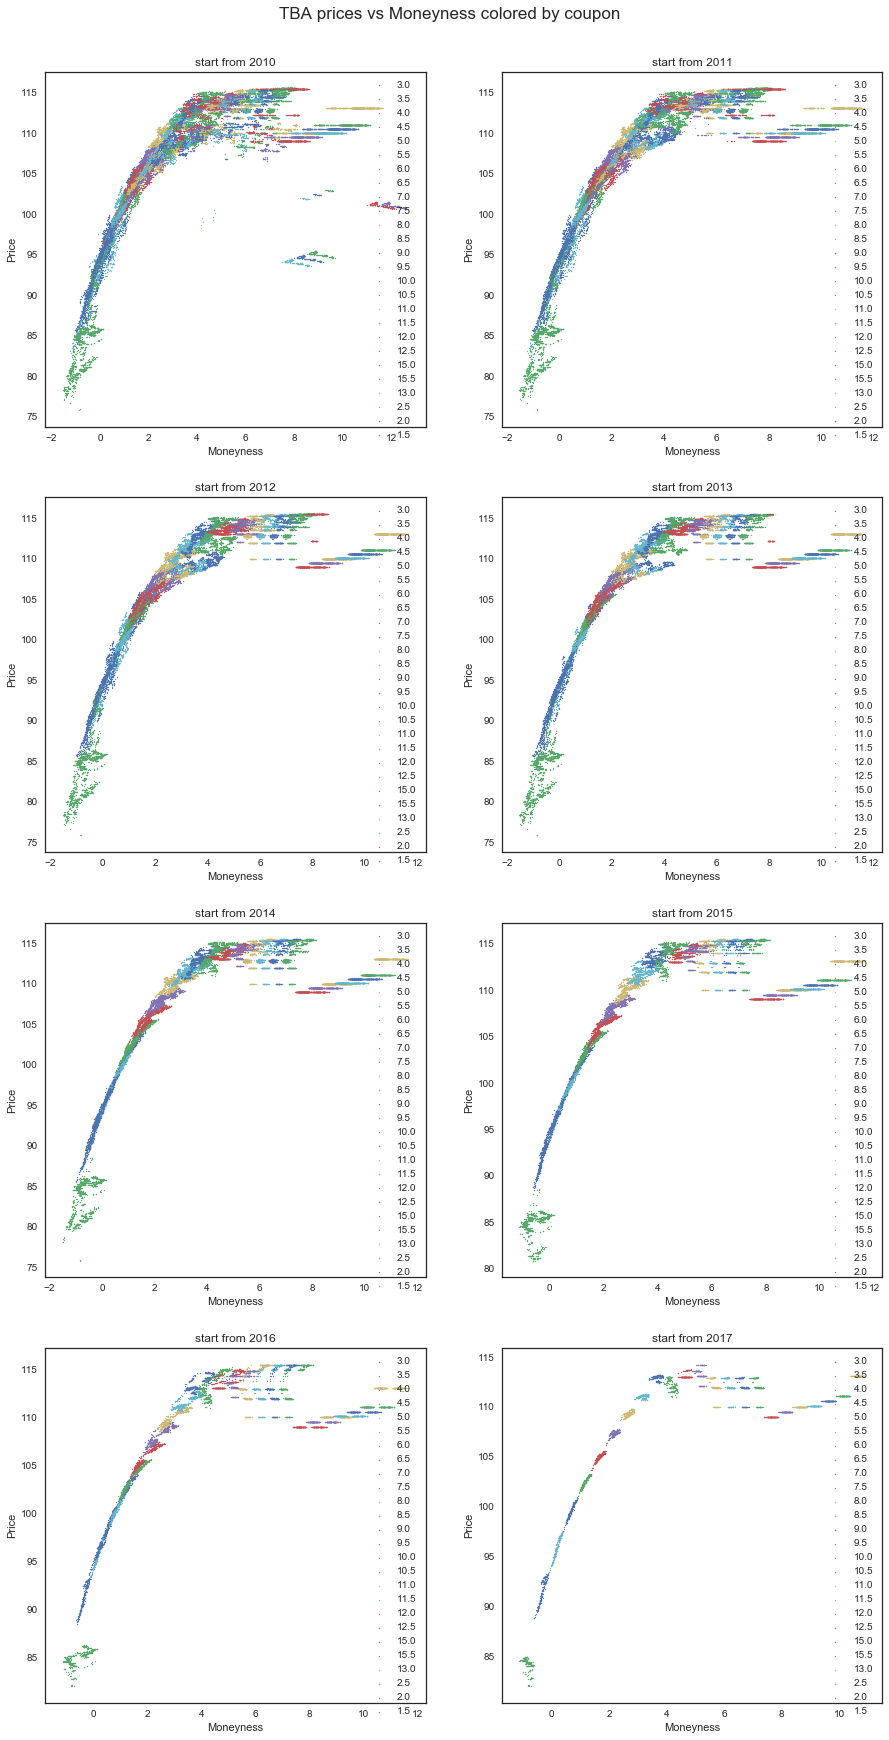

In [16]:
startYear=np.arange(2010,2018)
fig = plt.figure(figsize=(15,7.5*math.ceil(float(len(startYear))/2)))
plt.suptitle('TBA prices vs Moneyness colored by coupon', y=0.91, fontsize=17)
for i,y in enumerate(startYear):
    plt.subplot(math.ceil(float(len(startYear))/2),2,i+1)
    for k in df_aft2010['coupon'].unique():
        data = df_aft2010[df_aft2010['coupon']==k]
        data=data[str(y)+'-01-01':]
        plt.scatter(data['moneyness'], data['price'],s=1, label = str(k))
    plt.legend()
    plt.xlabel('Moneyness')
    plt.ylabel('Price')
    plt.title('start from '+ str(y))

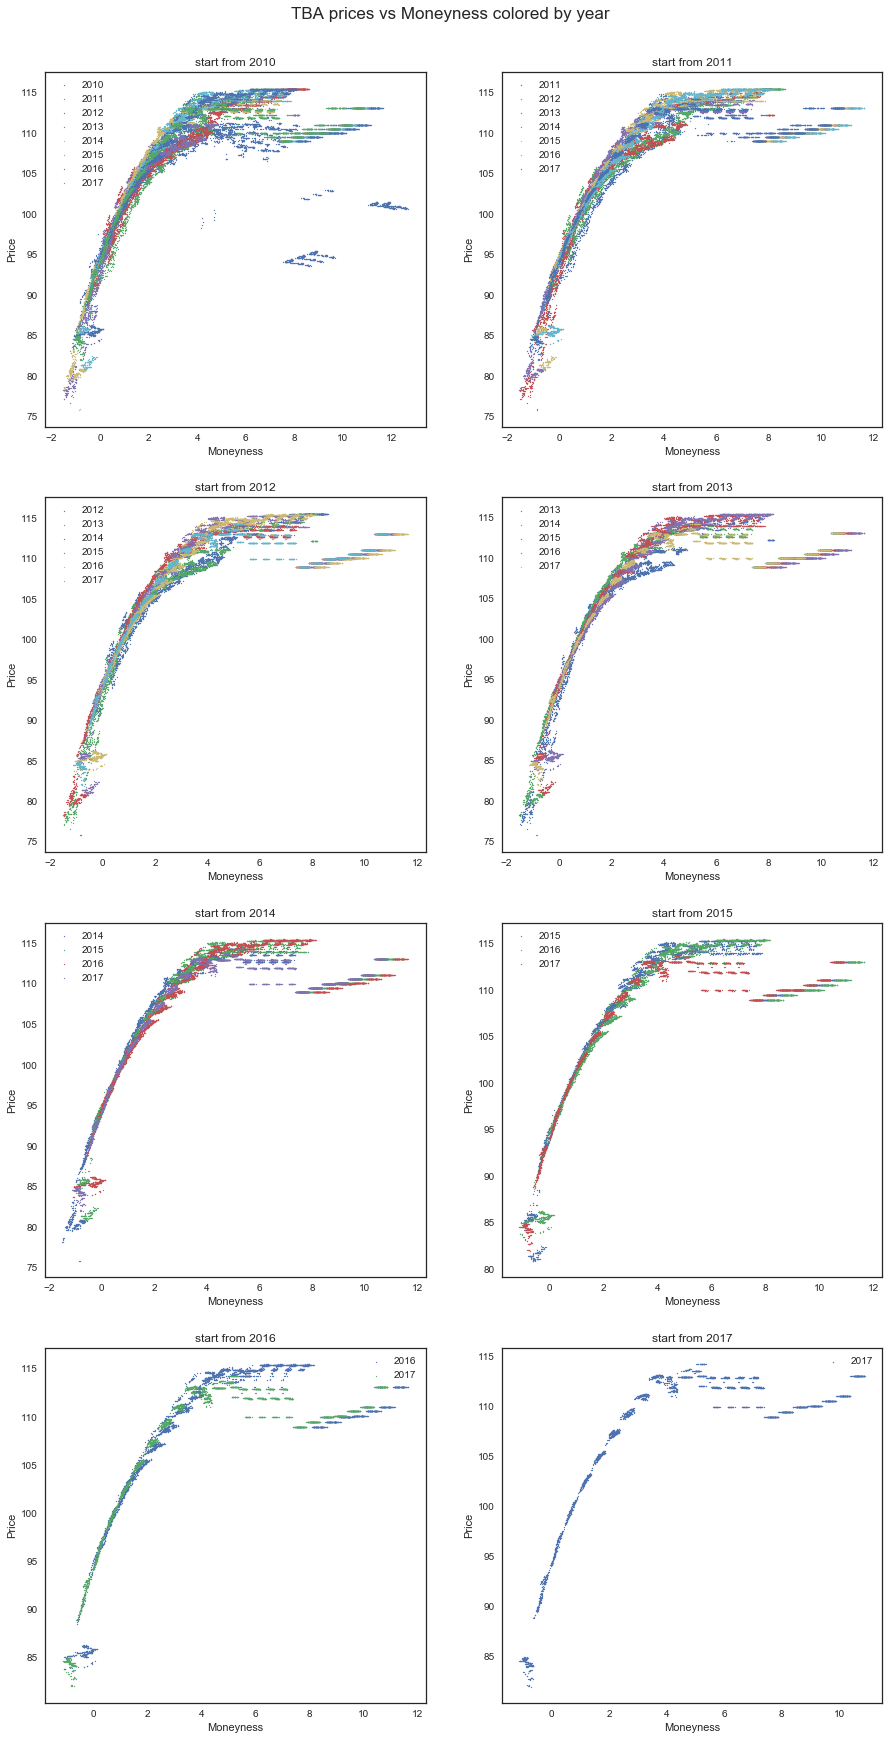

In [17]:
startYear=np.arange(2010,2018)
fig = plt.figure(figsize=(15,7.5*math.ceil(float(len(startYear))/2)))
plt.suptitle('TBA prices vs Moneyness colored by year', y=0.91, fontsize=17)
for i,y in enumerate(startYear):
    plt.subplot(math.ceil(float(len(startYear))/2),2,i+1)
    for k in startYear[i:]:
        data = df_aft2010[df_aft2010.index.year==k]
        plt.scatter(data['moneyness'], data['price'],s=1, label = str(k))
    plt.legend()
    plt.xlabel('Moneyness')
    plt.ylabel('Price')
    plt.title('start from '+ str(y))

## 4.2. Duration Hedging (* still use Tbill dummy data... until swaption data is available)

Using swaption as the heding instrument.
step 1) calculate dollar duration of both TBAs and swaption
$$\text{hedge ratio} = \dfrac{D_\$(\text{TBAs})}{D_\$(\text{swaption})}$$
step 2) construct hedged portfolio $$\Pi = \text{TBA price} - \text{hedge ratio}\times \text{swaption price} $$
step 3) compare the return and variance between the portfolio and naked position

In [18]:
tbill = pd.read_excel( '../data/1y tbill.xlsx',index_col=0, header=0)
tbill.head()

,Open,High,Low,Close,Price
Date,,,,,
2017-08-22,1.224,1.250,1.216,1.239,98.768644
2017-08-21,1.237,1.247,1.211,1.226,98.781485
2017-08-18,1.237,1.255,1.218,1.239,98.768644
2017-08-17,1.250,1.263,1.224,1.229,98.778521
2017-08-16,1.234,1.273,1.232,1.252,98.755805


In [19]:
startDate=tbill.index[-1]
result=[]
for c in poly_duration_without_order.keys(): #iterate for all coupons
    for item in poly_duration_without_order[c]: #iterate for all windows
        hedge=pd.DataFrame(item)
        for i,dataDate in enumerate(hedge.index):
            if dataDate >= startDate and len(hedge.index[i:])>1:
                hedgeUse=hedge[i:]
                nakedR=[np.nan]
                portfolioR=[np.nan]
                hr=[np.nan]
                d0=hedgeUse.index[0]
                for j,d in enumerate(hedgeUse.index[1:]):
                    try:
                        nakedReturn = (TBAs[c].price[d]-TBAs[c].price[d0])/TBAs[c].price[d0]
                        hedgeRatio=(hedgeUse['Duration'][d0]*TBAs[c].price[d0])/(1*float(tbill.Price[d0])) #duration of 1y ZCB is 1
                        pt=TBAs[c].price[d]-hedgeRatio*float(tbill.Price[d])
                        pt0=TBAs[c].price[d0]-hedgeRatio*float(tbill.Price[d0])
                        hedgedReturn=(pt-pt0)/pt0
                    except:  
                        nakedReturn=np.nan
                        hedgeRatio=np.nan
                        hedgedReturn=np.nan
                    nakedR.append(nakedReturn)
                    portfolioR.append(hedgedReturn)
                    hr.append(hedgeRatio)
                    d0=d
                hedgeUse['hedge_Ratio']=hr
                hedgeUse['naked_return']=nakedR
                hedgeUse['hedged_return']=portfolioR
                result.append([c,hedgeUse])
                break

### 4.2.1. Plot Hedged Ratio

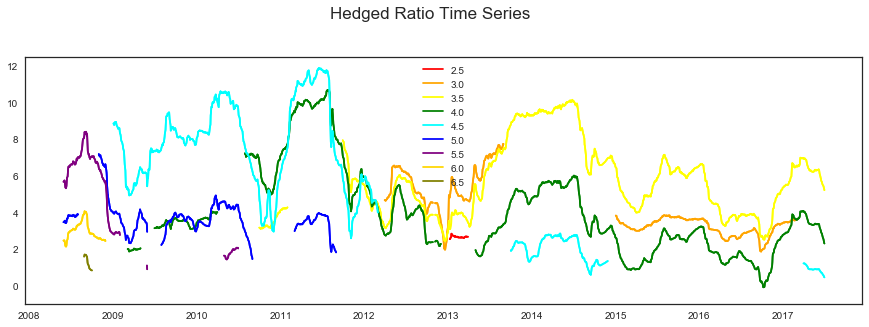

In [20]:
def getUniqLabel(handles, labels):
    uniq_label= {}
    for idx, lab in enumerate(labels):
        if lab not in uniq_label.keys():
            uniq_label[lab] = handles[idx]
    return uniq_label

color_code = {
    2.5: 'red',
    3.0: 'orange',
    3.5: 'yellow',
    4.0: 'green',
    4.5: 'cyan',
    5.0: 'blue',
    5.5: 'purple',
    6.0: 'gold',
    6.5: 'olive',
    7.0: 'brown',
    7.5: 'khaki',
    8.0: 'mediumslateblue',
    
}

fig = plt.figure(figsize = (15,10))
plt.suptitle('Hedged Ratio Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedge_Ratio'], c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys())

### 4.2.2. Plot Hedging Performance

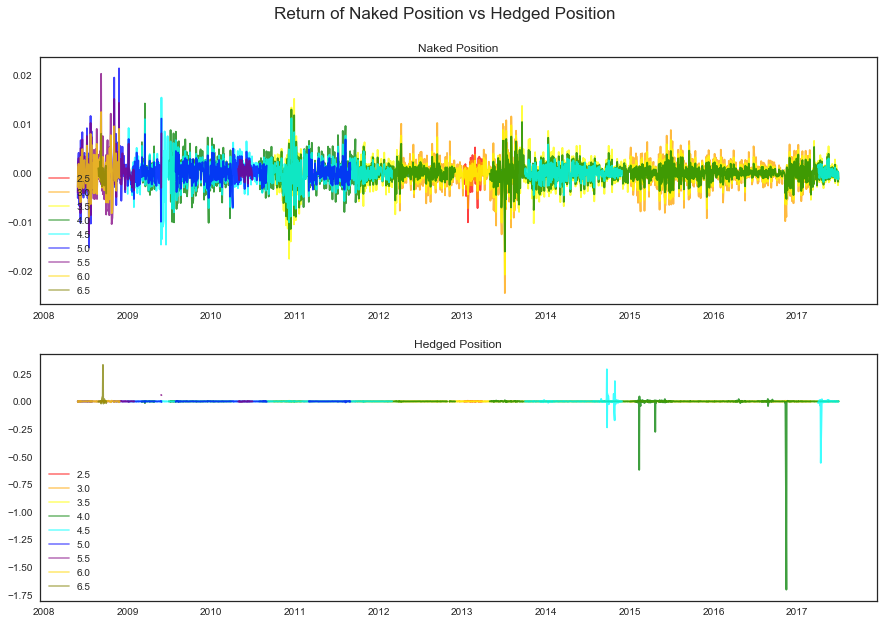

In [21]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Return of Naked Position vs Hedged Position', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['naked_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Naked Position')

ax = fig.add_subplot(212)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedged_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Hedged Position')